In [1]:
pip install wandb -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37807")

# Import

In [3]:
from IPython.display import clear_output
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm, trange
import xarray as xr
from IPython import display
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,Callback
import inspect
import itertools
import matplotlib.colors as mcolors
import glob, os
from random import randrange

In [4]:
import myParam3Ddata
import myTorchModels3D

In [5]:
import importlib

In [6]:
importlib.reload(myParam3Ddata)

<module 'myParam3Ddata' from '/home/jovyan/oceanDataNotebooks/density_ML/myParam3Ddata.py'>

In [7]:
import platform
print(platform.platform())

Linux-5.10.133+-x86_64-with-glibc2.35


In [8]:
print(torch.__version__)

1.13.1.post200


In [9]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")

# Useful functions

In [10]:
line_styles = ['solid', 'dashed', 'dotted', 'dashdot']

# Prepare data

In [11]:
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET'] 

In [12]:
data_dict=[dict() for i in range(6)]
data_dict[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR FMA'})
data_dict[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR ASO'})
data_dict[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'MIDATL FMA'})
data_dict[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'MIDATL ASO'})
data_dict[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED FMA'})
data_dict[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED ASO'})

In [13]:
features_to_add_to_sample = ['votemper', 'votemper_var', 'rho_ct_ct', 'diff_votemper_sqr']

In [14]:
auxiliary_features = ['z_l', 'f', 'e1t', 'e2t']

In [15]:
batch_size = 4

In [16]:
%%time
all_data = myParam3Ddata.PyLiDataModule(data_dict, features_to_add_to_sample, auxiliary_features, batch_size=batch_size)

CPU times: user 16 s, sys: 4.44 s, total: 20.5 s
Wall time: 1min 35s


# Run routine

In [17]:
def run_experiment(config, project) :
    wandb_logger = WandbLogger(name=config['model_label']+'_'+config['version'], \
                               version=config['model_label']+'_'+config['version'],\
                               project=project, config=config, resume=True, log_model=True)
    
    torch_model = eval(config['torch_model'])(**config['torch_model_params'])
    pylight_module = myParam3Ddata.GenericPyLiModule(torch_model, **config['module_params'])
    
    # Callbacks
    checkpoint_callback = ModelCheckpoint(monitor="loss_val", save_last=True)    
    early_stopping_callback = EarlyStopping(monitor="loss_val", mode="min")
    
    trainer = pl.Trainer(**config['training_params'], logger=wandb_logger, 
                     callbacks=[early_stopping_callback, checkpoint_callback],
                     accelerator='gpu', devices=(1 if torch.cuda.is_available() else None))  
    trainer.fit(model = pylight_module, datamodule=eval(config['datamodule']))
    #tests
    test_datamodule = eval(config['datamodule'])
    test_datamodule.setup(stage='test')
    trainer.test(model = pylight_module, datamodule=test_datamodule)
    wandb.finish()

# List of configs

In [18]:
list_of_configs = list()

## Linear regression

In [19]:
list_of_configs.append(dict({'model_label' : 'LinReg',
                'version' : 'valueHuberLoss',
                'torch_model' : 'myTorchModels3D.lin_regr_model',
                'datamodule' : 'all_data',
                'torch_model_params' : dict({'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1}),
                'module_params' : dict({'input_features'  : ['diff_votemper_sqr'],
                                        'output_features'  : ['votemper_var'],
                                        'output_units' : None,
                                        'loss' : torch.nn.functional.huber_loss,
                                        'optimizer' : torch.optim.SGD,
                                        'learning_rate' : 1e-3,}),
                'training_params' : dict({'max_epochs' : 100,
                                          'limit_train_batches' : 1.0})
               }))

In [20]:
list_of_configs.append(dict({'model_label' : 'LinReg',
                'version' : 'valueMSELoss',
                'torch_model' : 'myTorchModels3D.lin_regr_model',
                'datamodule' : 'all_data',
                'torch_model_params' : dict({'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1}),
                'module_params' : dict({'input_features'  : ['diff_votemper_sqr'],
                                        'output_features'  : ['votemper_var'],
                                        'output_units' : None,
                                        'loss' : torch.nn.functional.mse_loss,
                                        'optimizer' : torch.optim.SGD,
                                        'learning_rate' : 1e-3,}),
                'training_params' : dict({'max_epochs' : 100,
                                          'limit_train_batches' : 1.0})
               }))

In [21]:
list_of_configs.append(dict({'model_label' : 'LinReg',
                'version' : 'gradLoss',
                'torch_model' : 'myTorchModels3D.lin_regr_model',
                'datamodule' : 'all_data',
                'torch_model_params' : dict({'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1}),
                'module_params' : dict({'input_features'  : ['diff_votemper_sqr'],
                                        'output_features'  : ['votemper_var'],
                                        'output_units' : None,
                                        'loss' : myParam3Ddata.gradient_based_MSEloss,
                                        'optimizer' : torch.optim.SGD,
                                        'learning_rate' : 1e-3,}),
                'training_params' : dict({'max_epochs' : 100,
                                          'limit_train_batches' : 1.0})
               }))

## FCNN on patches

In [22]:
list_of_configs.append(dict({'model_label' : 'FCNN',
                'version' : 'patch_in3_out1_val_loss',
                'torch_model' : 'myTorchModels3D.FCNN',
                'datamodule' : 'all_data',
                'torch_model_params' : dict({'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1, \
                                            'input_patch_size' : 3,
                                            'output_patch_size' : 1, 
                                            'int_layer_width' : 50}),
                'module_params' : dict({'input_features'  : ['votemper'],
                                        'output_features'  : ['votemper_var'],
                                        'output_units' : ['diff_votemper_sqr'],
                                        'loss' : torch.nn.functional.mse_loss,
                                        'optimizer' : torch.optim.Adam,
                                        'learning_rate' : 1e-3,}),
                'training_params' : dict({'max_epochs' : 100,
                                          'limit_train_batches' : 1.0})
               }))

In [23]:
list_of_configs.append(dict({'model_label' : 'FCNN',
                'version' : 'patch_in3_out1_pres_loss',
                'torch_model' : 'myTorchModels3D.FCNN',
                'datamodule' : 'all_data',
                'torch_model_params' : dict({'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1, \
                                            'input_patch_size' : 3,
                                            'output_patch_size' : 1, 
                                            'int_layer_width' : 50}),
                'module_params' : dict({'input_features'  : ['votemper'],
                                        'output_features'  : ['votemper_var'],
                                        'output_units' : ['diff_votemper_sqr'],
                                        'loss' : 'pressure_based_MSEloss',
                                        'optimizer' : torch.optim.Adam,
                                        'learning_rate' : 1e-3,}),
                'training_params' : dict({'max_epochs' : 100,
                                          'limit_train_batches' : 1.0})
               }))

In [24]:
list_of_configs.append(dict({'model_label' : 'FCNN',
                'version' : 'patch_in3_out3_val_loss',
                'torch_model' : 'myTorchModels3D.FCNN',
                'datamodule' : 'all_data',
                'torch_model_params' : dict({'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1, \
                                            'input_patch_size' : 3,
                                            'output_patch_size' : 3, 
                                            'int_layer_width' : 50}),
                'module_params' : dict({'input_features'  : ['votemper'],
                                        'output_features'  : ['votemper_var'],
                                        'output_units' : ['diff_votemper_sqr'],
                                        'loss' : torch.nn.functional.mse_loss,
                                        'optimizer' : torch.optim.Adam,
                                        'learning_rate' : 1e-3,}),
                'training_params' : dict({'max_epochs' : 100,
                                          'limit_train_batches' : 1.0})
               }))

In [25]:
list_of_configs.append(dict({'model_label' : 'FCNN',
                'version' : 'patch_in3_out3_press_loss',
                'torch_model' : 'myTorchModels3D.FCNN',
                'datamodule' : 'all_data',
                'torch_model_params' : dict({'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1, \
                                            'input_patch_size' : 3,
                                            'output_patch_size' : 3, 
                                            'int_layer_width' : 50}),
                'module_params' : dict({'input_features'  : ['votemper'],
                                        'output_features'  : ['votemper_var'],
                                        'output_units' : ['diff_votemper_sqr'],
                                        'loss' : 'pressure_based_MSEloss',
                                        'optimizer' : torch.optim.Adam,
                                        'learning_rate' : 1e-3,}),
                'training_params' : dict({'max_epochs' : 100,
                                          'limit_train_batches' : 1.0})
               }))

In [26]:
list_of_configs.append(dict({'model_label' : 'FCNN',
                'version' : 'patch_in5_out3_val_loss',
                'torch_model' : 'myTorchModels3D.FCNN',
                'datamodule' : 'all_data',
                'torch_model_params' : dict({'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1, \
                                            'input_patch_size' : 5,
                                            'output_patch_size' : 3, 
                                            'int_layer_width' : 50}),
                'module_params' : dict({'input_features'  : ['votemper'],
                                        'output_features'  : ['votemper_var'],
                                        'output_units' : ['diff_votemper_sqr'],
                                        'loss' : torch.nn.functional.mse_loss,
                                        'optimizer' : torch.optim.Adam,
                                        'learning_rate' : 1e-3,}),
                'training_params' : dict({'max_epochs' : 100,
                                          'limit_train_batches' : 1.0})
               }))

In [27]:
list_of_configs.append(dict({'model_label' : 'FCNN',
                'version' : 'patch_in5_out3_pres_loss',
                'torch_model' : 'myTorchModels3D.FCNN',
                'datamodule' : 'all_data',
                'torch_model_params' : dict({'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1, \
                                            'input_patch_size' : 5,
                                            'output_patch_size' : 3, 
                                            'int_layer_width' : 50}),
                'module_params' : dict({'input_features'  : ['votemper'],
                                        'output_features'  : ['votemper_var'],
                                        'output_units' : ['diff_votemper_sqr'],
                                        'loss' : 'pressure_based_MSEloss',
                                        'optimizer' : torch.optim.Adam,
                                        'learning_rate' : 1e-3,}),
                'training_params' : dict({'max_epochs' : 100,
                                          'limit_train_batches' : 1.0})
               }))

In [28]:
# list_of_configs.append(dict({'model_label' : 'FCNN',
#                 'version' : 'patch_in7_out5_nd',
#                 'torch_model' : 'myTorchModels3D.FCNN',
#                 'datamodule' : 'all_data',
#                 'torch_model_params' : dict({'nb_of_input_features' : 1, \
#                                             'nb_of_output_features' : 1, \
#                                             'input_patch_size' : 7,
#                                             'output_patch_size' : 5, 
#                                             'int_layer_width' : 50}),
#                 'module_params' : dict({'input_features'  : ['votemper'],
#                                         'output_features'  : ['votemper_var'],
#                                         'output_units' : ['diff_votemper_sqr'],
#                                         'loss' : torch.nn.functional.mse_loss,
#                                         'optimizer' : torch.optim.Adam,
#                                         'learning_rate' : 1e-3,}),
#                 'training_params' : dict({'max_epochs' : 100,
#                                           'limit_train_batches' : 1.0})
#                }))

## CNN

In [29]:
list_of_configs.append(dict({'model_label' : 'CNN',
                'version' : 'kernel3_val',
                'torch_model' : 'myTorchModels3D.CNN',
                'datamodule' : 'all_data',
                'torch_model_params' : dict({'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1, \
                                             'kernel_size' : 3, \
                                            'int_layer_width' : 64}),
                'module_params' : dict({'input_features'  : ['votemper'],
                                        'output_features'  : ['votemper_var'],
                                        'output_units' : ['diff_votemper_sqr'],
                                        'loss' : torch.nn.functional.mse_loss,
                                        'optimizer' : torch.optim.Adam,
                                        'learning_rate' : 1e-3,}),
                'training_params' : dict({'max_epochs' : 100,
                                          'limit_train_batches' : 1.0})
               }))

In [30]:
list_of_configs.append(dict({'model_label' : 'CNN',
                'version' : 'kernel3_pres',
                'torch_model' : 'myTorchModels3D.CNN',
                'datamodule' : 'all_data',
                'torch_model_params' : dict({'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1, \
                                             'kernel_size' : 3, \
                                            'int_layer_width' : 64}),
                'module_params' : dict({'input_features'  : ['votemper'],
                                        'output_features'  : ['votemper_var'],
                                        'output_units' : ['diff_votemper_sqr'],
                                        'loss' : 'pressure_based_MSEloss',
                                        'optimizer' : torch.optim.Adam,
                                        'learning_rate' : 1e-3,}),
                'training_params' : dict({'max_epochs' : 100,
                                          'limit_train_batches' : 1.0})
               }))

In [31]:
list_of_configs.append(dict({'model_label' : 'CNN',
                'version' : 'kernel5_nd',
                'torch_model' : 'myTorchModels3D.CNN',
                'datamodule' : 'all_data',
                'torch_model_params' : dict({'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1, \
                                             'kernel_size' : 5, \
                                            'int_layer_width' : 64}),
                'module_params' : dict({'input_features'  : ['votemper'],
                                        'output_features'  : ['votemper_var'],
                                        'output_units' : ['diff_votemper_sqr'],
                                        'loss' : torch.nn.functional.mse_loss,
                                        'optimizer' : torch.optim.Adam,
                                        'learning_rate' : 1e-3,}),
                'training_params' : dict({'max_epochs' : 100,
                                          'limit_train_batches' : 1.0})
               }))

In [32]:
list_of_configs.append(dict({'model_label' : 'CNN',
                'version' : 'kernel5_pres',
                'torch_model' : 'myTorchModels3D.CNN',
                'datamodule' : 'all_data',
                'torch_model_params' : dict({'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1, \
                                             'kernel_size' : 5, \
                                            'int_layer_width' : 64}),
                'module_params' : dict({'input_features'  : ['votemper'],
                                        'output_features'  : ['votemper_var'],
                                        'output_units' : ['diff_votemper_sqr'],
                                        'loss' : 'pressure_based_MSEloss',
                                        'optimizer' : torch.optim.Adam,
                                        'learning_rate' : 1e-3,}),
                'training_params' : dict({'max_epochs' : 100,
                                          'limit_train_batches' : 1.0})
               }))

# Runs

In [33]:
len(list_of_configs)

13

In [34]:
project_name = 'tests'

In [35]:
wandb.finish()

In [36]:
# for config in list_of_configs :
#     run_experiment(config, project_name)

# Load checkpoints

In [37]:
api = wandb.Api()

In [38]:
list_of_models = [dict() for i in range(len(list_of_configs))]

In [39]:
for i, config in enumerate(list_of_configs) : 
    checkpoint_reference = 'anagorb63/'+project_name+"/model-"+config['model_label']+'_'+config['version']+':v0'
    artifact = api.artifact(checkpoint_reference)
    artifact_dir = artifact.download()
    list_of_models[i]['best'] = myParam3Ddata.GenericPyLiModule.load_from_checkpoint(os.path.abspath(artifact_dir)+"/model.ckpt")
    list_of_models[i]['label'] = config['model_label']+'_'+config['version']
    list_of_models[i]['model_name'] = config['model_label']
    list_of_models[i]['version'] = config['version']

wandb:   1 of 1 files downloaded.  
/srv/conda/envs/notebook/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'torch_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['torch_model'])`.
  rank_zero_warn(
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


# Get predictions

In [40]:
%%time
test_datamodule = all_data
test_datamodule.setup(stage='test')

CPU times: user 349 µs, sys: 0 ns, total: 349 µs
Wall time: 95.8 µs


In [41]:
%%time
for i, model in enumerate(list_of_models) :
    trainer = pl.Trainer(accelerator='gpu', devices=1)
    model['pred'] = dict()
    prediction_dict = trainer.predict(model['best'], dataloaders=test_datamodule.test_dataloader())
    for feature in list(prediction_dict[0][0].keys()) :
        model['pred'][feature] = [prediction_dict[idx_dataset][0][feature] for idx_dataset in range(len(test_datamodule.test_dataloader()))]
    del prediction_dict

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

CPU times: user 1min 5s, sys: 6.49 s, total: 1min 12s
Wall time: 23.3 s


# Get ground truth

In [42]:
truth = dict()
for feature in ['votemper_var', 'rho_ct_ct', 'f', 'e1t', 'e2t'] :
    truth[feature] = [torch.Tensor() for i in range(len(test_datamodule.test_dataloader()))]

In [43]:
for i, dataloader in enumerate(test_datamodule.test_dataloader()) :
    iterator = iter(dataloader)
    sample = next(iterator)
    for feature in ['votemper_var', 'rho_ct_ct', 'e1t', 'e2t'] :
        if (len(sample[feature].shape) == 4) :
            truth[feature][i] = sample[feature].where(sample['mask'][:,None,:,:], torch.ones_like(sample['mask'][:,None,:,:])*np.nan)
        if (len(sample[feature].shape) == 3) :
            truth[feature][i] = sample[feature].where(sample['mask'], torch.ones_like(sample['mask'])*np.nan)        

# Get logged metrics

In [44]:
metrics_list = ['loss_val', 'loss_grad', 'corr_coef', 'corr_coef_grad']

In [45]:
feature_list = ['votemper_var']

In [46]:
for i, model in enumerate(list_of_models) : 
    run_id = model['label']
    run = api.run("anagorb63/"+project_name+"/"+run_id)
    metrics_table = run.history().iloc[-1]
    for feature in feature_list :
        model[feature] = dict()
        for metrics in metrics_list :
            model[feature][metrics] = [metrics_table[metrics+'_'+feature+'/dataloader_idx_'+str(idx)] for idx in range(len(test_datamodule.test_dataloader()))]
    model['pressure_grad'] = dict()
    model['pressure_grad']['loss_val'] = [metrics_table['loss_val_pressure_grad/dataloader_idx_'+str(idx)] for idx in range(len(test_datamodule.test_dataloader()))]

# Image examples

In [47]:
def plot_snapshots_at_2depths(idx_batch, idx_levels, idx_region, feature) : 
    fig, axs = plt.subplots(nrows=2, ncols=1, constrained_layout=True, figsize=(2*(len(list_of_models)+1),5),sharex=True, sharey=True)
    fig.suptitle('Snapshots in ' + data_dict[idx_region]['label'])

    # clear subplots
    for ax in axs:
        ax.remove()

    # add subfigure per subplot
    gridspec = axs[0].get_subplotspec().get_gridspec()
    subfigs = [fig.add_subfigure(gs) for gs in gridspec]

    for row, subfig in enumerate(subfigs):
        axs = subfig.subplots(ncols=len(list_of_models)+1, nrows=1, sharex=True, sharey=True)
        img = axs[0].imshow(truth[feature][idx_region][idx_batch,idx_levels[row],:,:], \
                            cmap=('ocean_r' if (row==0) else current_cmap), \
                            #vmin=(None if (row==0) else color_min), vmax=(None if (row==0) else color_max), \
                            origin='lower')
        fig.colorbar(img, location='left',  shrink=0.8)
        axs[0].set(title='Truth')
        #if (row == 0) :
        color_min = img.colorbar.vmin
        color_max = img.colorbar.vmax
        current_cmap = img.cmap
        current_cmap.set_bad(color='silver')

        for i, model in enumerate(list_of_models) :
            img = axs[i+1].imshow(model['pred'][feature + '_masked'][idx_region][idx_batch,idx_levels[row],:,:], cmap=current_cmap, \
                                           vmin=color_min, vmax=color_max, origin='lower')
            axs[i+1].set(title=model['label'])
        fig.colorbar(img, ax=axs[-1], shrink=0.8)
    subfigs[0].suptitle('On the surface')
    subfigs[1].suptitle('At depth')
    plt.show()

In [48]:
idx_batch = 0

In [49]:
idx_levels = [0,106]

## Region 1 : Gulfstream (FMA)

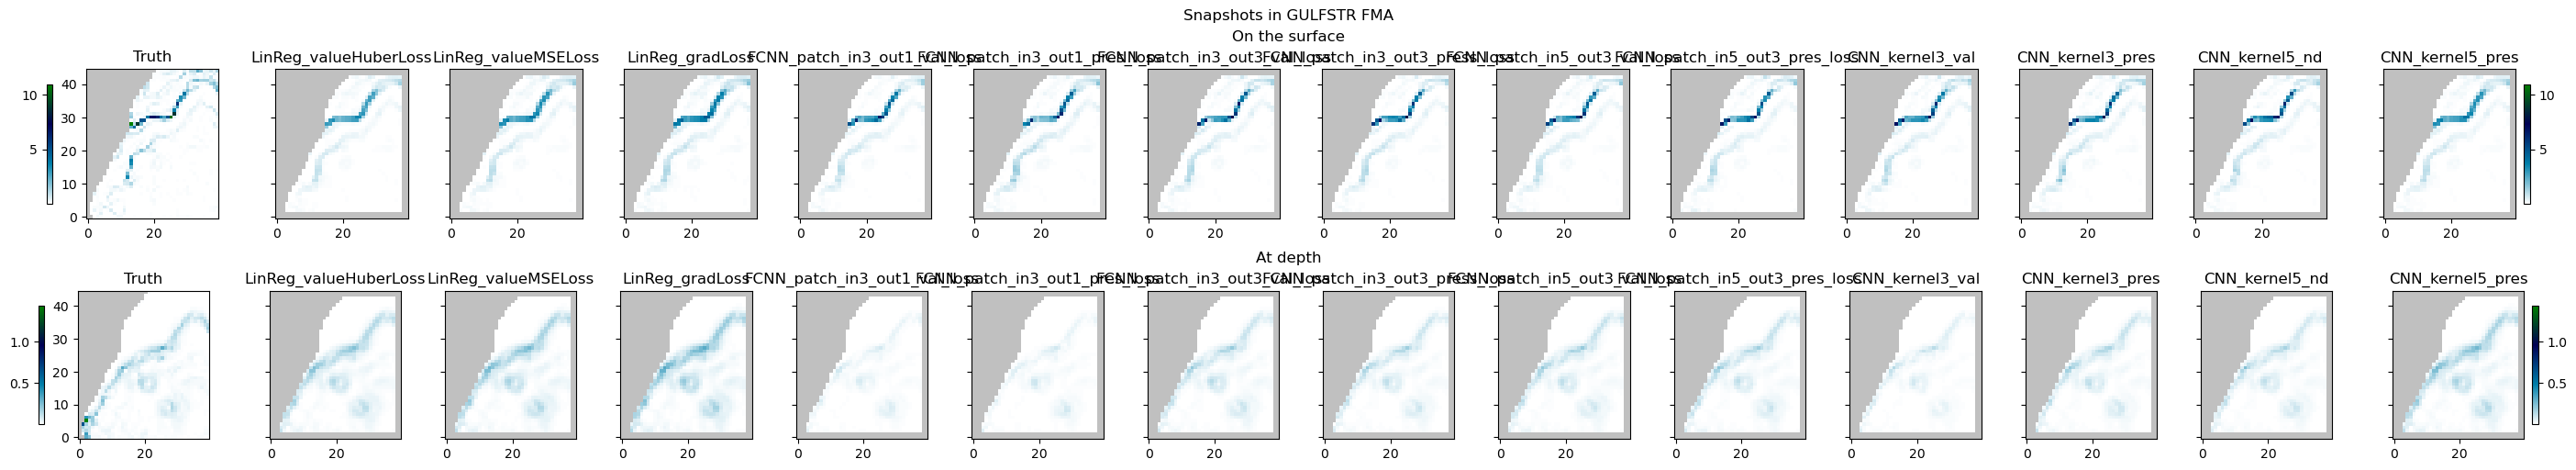

In [50]:
idx_region = 0

plot_snapshots_at_2depths(idx_batch, idx_levels, idx_region, 'votemper_var')

## Region 2 - Mid Atlantic (ASO)

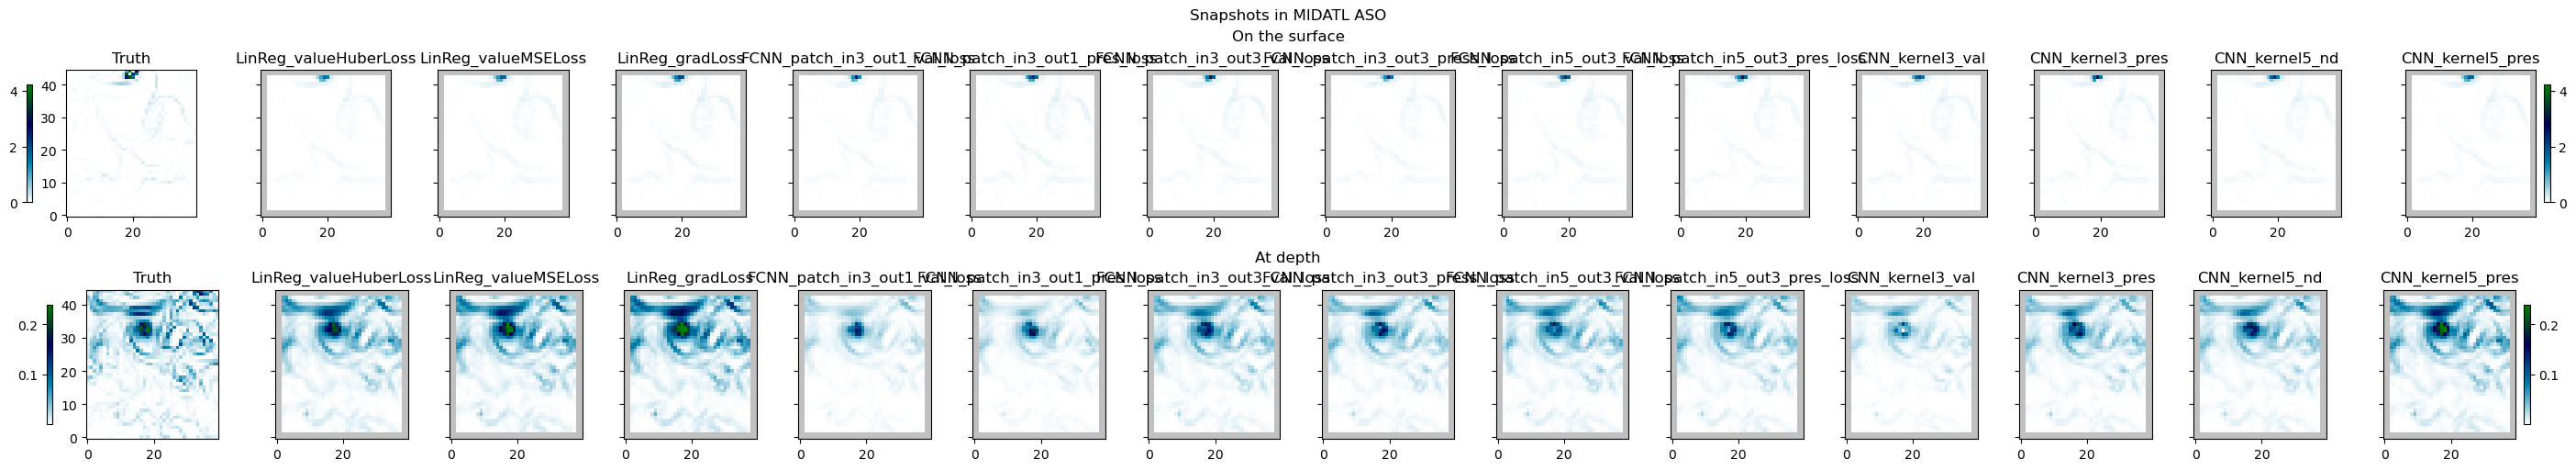

In [51]:
idx_region = 3

plot_snapshots_at_2depths(idx_batch, idx_levels, idx_region, 'votemper_var')

## Region 3 - WEDMED (ASO)

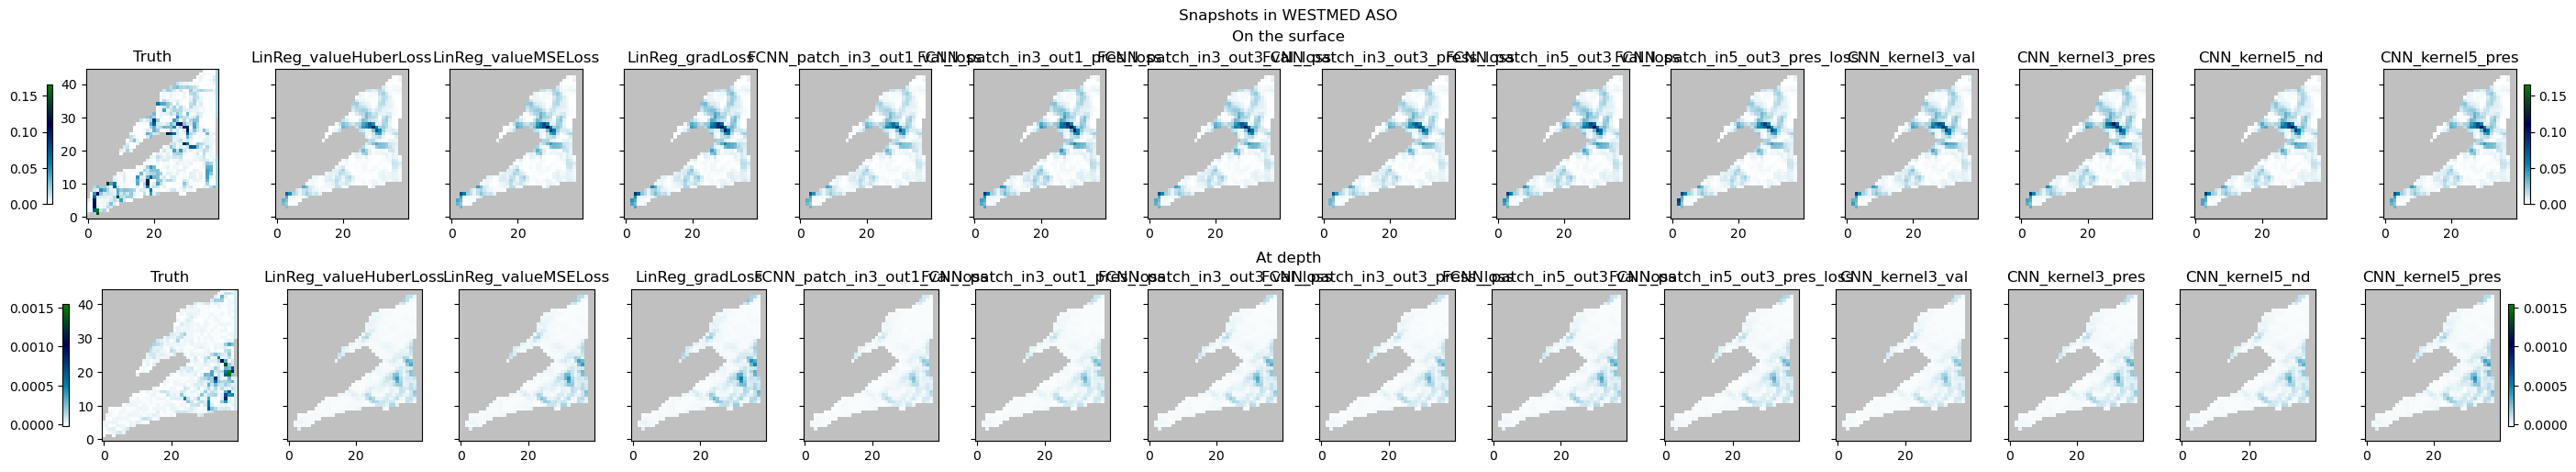

In [52]:
idx_region = 5

plot_snapshots_at_2depths(idx_batch, idx_levels, idx_region, 'votemper_var')

# Metrics over all datasets

In [53]:
bar_colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.BASE_COLORS.values())

In [54]:
xlabels = ['LinReg', 'FCNN', 'CNN']

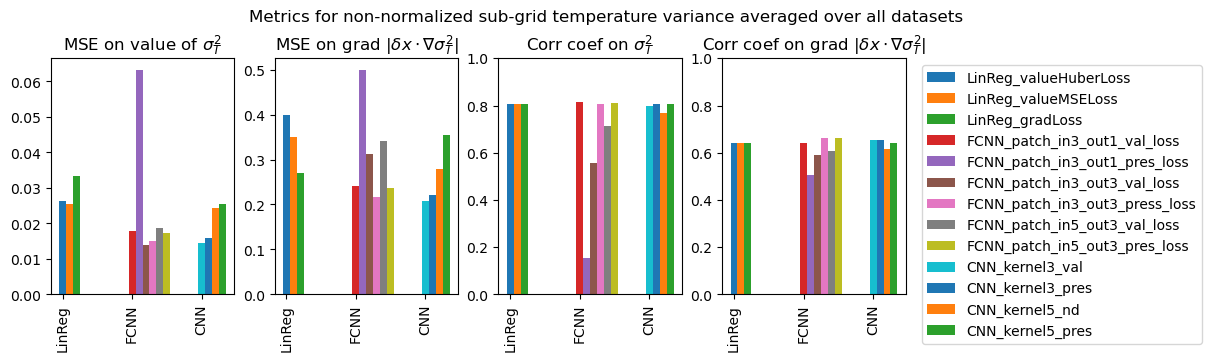

In [55]:
fig, ax = plt.subplots(1, len(metrics_list), constrained_layout=True, figsize=(3.0*len(metrics_list), 3.5), sharex=True)
fig.suptitle('Metrics for non-normalized sub-grid temperature variance averaged over all datasets')
x = np.arange(3)
versions = [0 for i in x]
bar_width = 0.1
feature = 'votemper_var'
for idx_model, model in enumerate(list_of_models) :
    i = xlabels.index(model['model_name'])
    j = versions[i]
    for idx, metrics in enumerate(metrics_list) :
        ax[idx].bar(x[i]+j*bar_width, np.mean(model[feature][metrics]), width=bar_width, label=model['label'])
        ax[idx].set_xticks(x, xlabels, rotation='vertical') 
    versions[i]+=1
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
for axis in ax[2::] :
    axis.set(ylim=[0,1])

ax[0].set(title=r'MSE on value of $\sigma_T^2$')
ax[1].set(title=r'MSE on grad $|\delta x \cdot \nabla \sigma_T^2|$')
ax[2].set(title=r'Corr coef on $\sigma_T^2$')
ax[3].set(title=r'Corr coef on grad $|\delta x \cdot \nabla \sigma_T^2|$')
plt.show()

## MSE across datasets (by region/season)

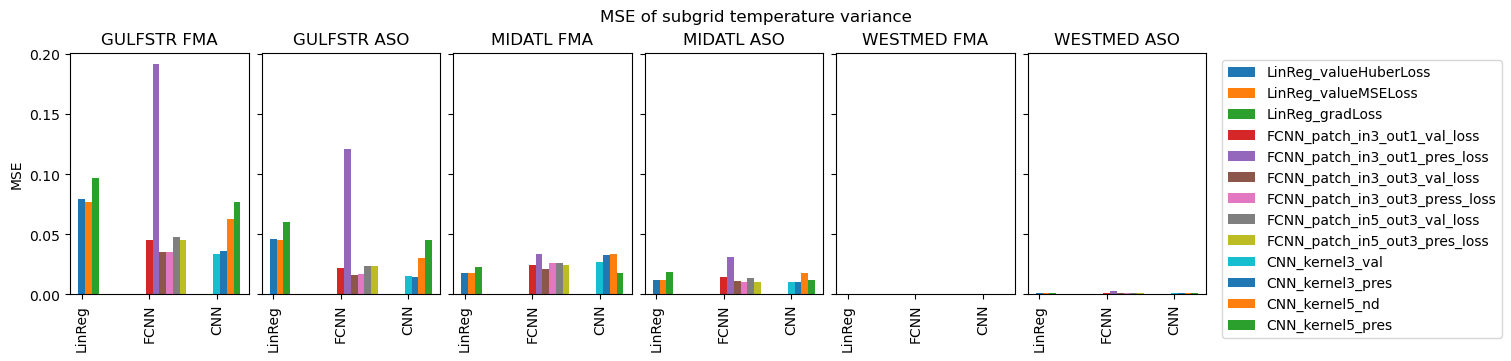

In [56]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.5), sharex=True, sharey=True)
fig.suptitle('MSE of subgrid temperature variance')

feature = 'votemper_var'
metrics = 'loss_val'
for region in range(len(data_dict)) :
    versions = [0 for i in x]
    for idx_model, model in enumerate(list_of_models) :
        i = xlabels.index(model['model_name'])
        j = versions[i]
        ax[region].bar(x[i]+j*bar_width, model[feature][metrics][region], width=bar_width, label=model['label'])
        versions[i]+=1
    ax[region].set_xticks(x, xlabels, rotation='vertical')
    ax[region].set(title=data_dict[region]['label'])
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Vertical profiles

In [57]:
nb_of_random_points = 6

In [58]:
random_points = [dict() for i in range(nb_of_random_points)]

In [59]:
i = 0
while (i < nb_of_random_points) : 
    x = randrange(2,sample['votemper_var'].shape[3]-9)
    y = randrange(2,sample['votemper_var'].shape[2]-9)
    if (sample['eroded_mask'][0,x,y] > 0) :
        random_points[i] = dict({'x': x, 'y': y})
        i+=1
    else :
        continue

In [60]:
random_points

[{'x': 26, 'y': 34},
 {'x': 19, 'y': 31},
 {'x': 5, 'y': 6},
 {'x': 24, 'y': 32},
 {'x': 19, 'y': 32},
 {'x': 10, 'y': 31}]

In [61]:
idx_region = 0
idx_batch = 0

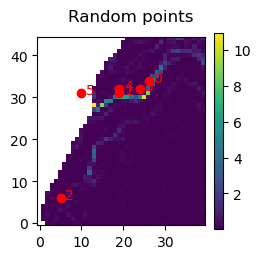

In [62]:
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(2.5,2.5),sharex=True, sharey=True)
fig.suptitle('Random points')
img = axs.imshow(truth['votemper_var'][idx_region][idx_batch,0,:,:], origin='lower')
xs=[point['x'] for point in random_points]
ys=[point['y'] for point in random_points]
for i, point in enumerate(random_points) : 
    axs.annotate(str(i), xy=(point['x'], point['y']), color='red', xytext=(3.5, -1), textcoords="offset points",)
axs.scatter(xs,ys, color='red')
fig.colorbar(img)
plt.show()

## Subgrid temp variance

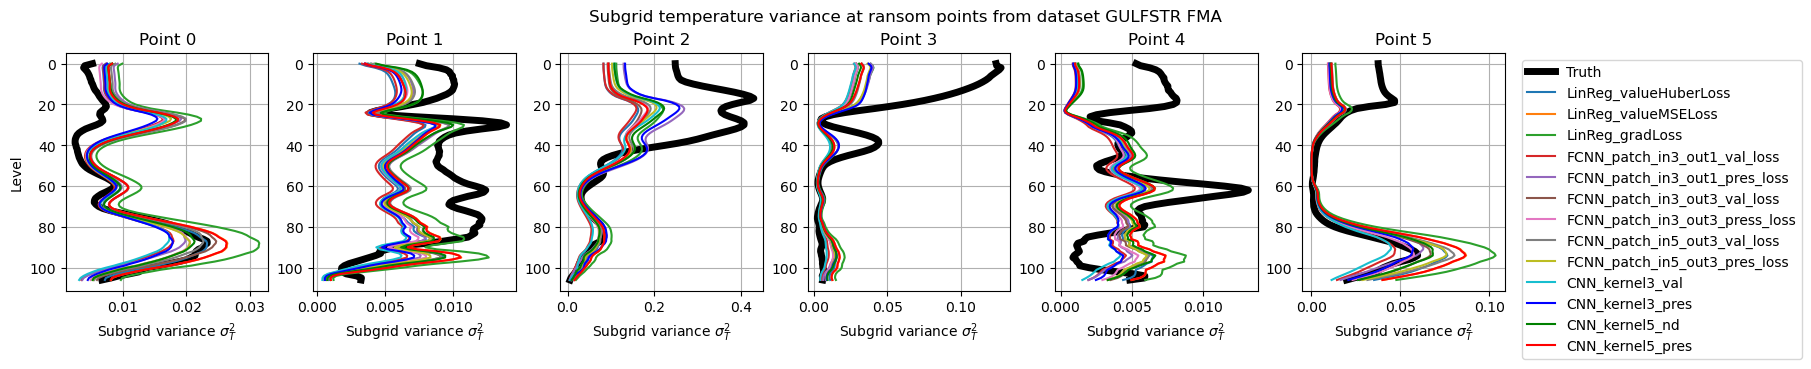

In [63]:
fig, ax = plt.subplots(1, len(random_points), constrained_layout=True, figsize=(3*len(random_points), 3.5), sharex=False,sharey=False)
y_vals = np.arange(truth['votemper_var'][idx_region].shape[1])
fig.suptitle('Subgrid temperature variance at ransom points from dataset '+data_dict[idx_region]['label'])

for idx, point in enumerate(random_points):
    x = point['x']
    y = point['y']
    x_vals = truth['votemper_var'][idx_region][idx_batch,:,x,y]
    ax[idx].plot(x_vals, y_vals, label='Truth', lw=5, color='k')
    for i, model in enumerate(list_of_models) :
        x_vals = model['pred']['votemper_var_masked'][idx_region][idx_batch,:,x,y]
        ax[idx].plot(x_vals, y_vals, label=model['label'], color=bar_colors[i])
    ax[idx].invert_yaxis() 
    ax[idx].set(xlabel=r'Subgrid variance $\sigma_T^2$', title='Point '+str(idx))
    ax[idx].grid(True)
ax[0].set(ylabel='Level')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

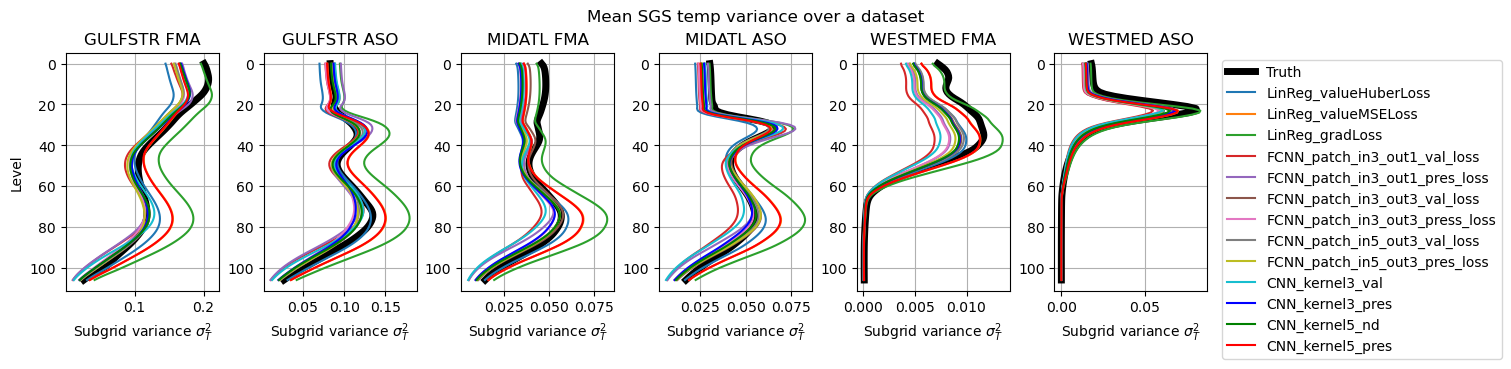

In [64]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.5))
y_vals = np.arange(truth['votemper_var'][idx_region].shape[1])
fig.suptitle('Mean SGS temp variance over a dataset')

for idx_region in range(len(data_dict)) :
    ax[idx_region].plot(np.nanmean(truth['votemper_var'][idx_region], axis=(0,2,3)), y_vals, label='Truth', lw=5, color='k')
    line_counter=1
    for i, model in enumerate(list_of_models) :
        x_vals = np.nanmean(model['pred']['votemper_var_masked'][idx_region][:,:,:], axis=(0,2,3))
        ax[idx_region].plot(x_vals, y_vals, label=model['label'], ls='-', color=bar_colors[i])
    ax[idx_region].invert_yaxis() 
    ax[idx_region].set(title=data_dict[idx_region]['label'],xlabel=r'Subgrid variance $\sigma_T^2$')
    ax[idx_region].grid(True)
ax[0].set(ylabel='Level')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Profiles of MSE

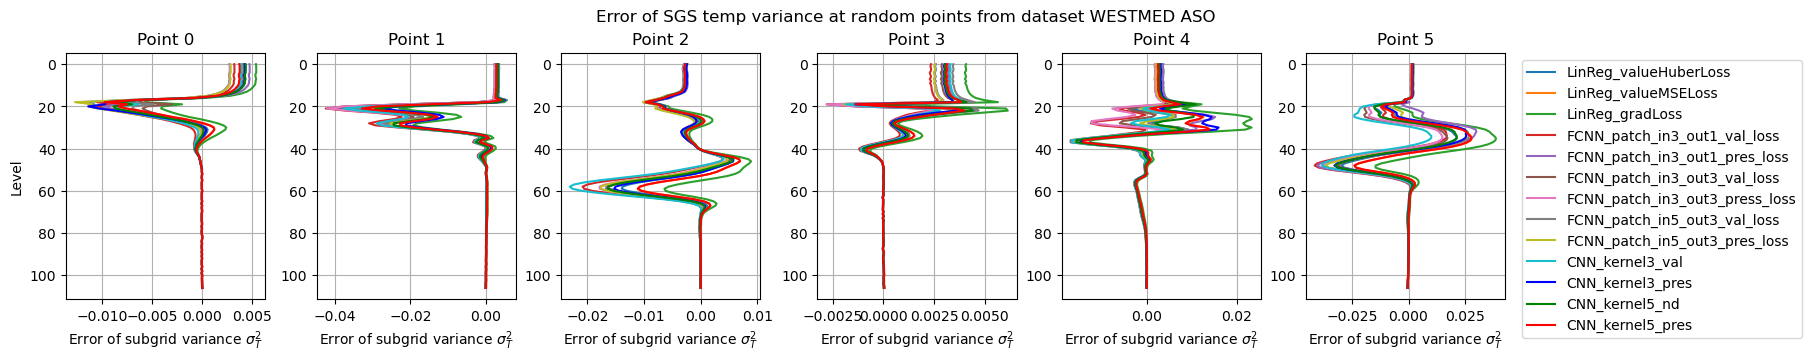

In [65]:
fig, ax = plt.subplots(1, len(random_points), constrained_layout=True, figsize=(3*len(random_points), 3.5), sharex=False,sharey=False)
y_vals = np.arange(truth['votemper_var'][idx_region].shape[1])
fig.suptitle('Error of SGS temp variance at random points from dataset '+data_dict[idx_region]['label'])

for idx, point in enumerate(random_points):
    x = point['x']
    y = point['y']
    line_counter = 1
    for i, model in enumerate(list_of_models) :
        x_vals = model['pred']['votemper_var_masked'][idx_region][idx_batch,:,x,y]-truth['votemper_var'][idx_region][idx_batch,:,x,y]
        ax[idx].plot(x_vals, y_vals, label=model['label'], color=bar_colors[i])
    ax[idx].invert_yaxis() 
    ax[idx].set(xlabel=r'Error of subgrid variance $\sigma_T^2$', title='Point '+str(idx))
    ax[idx].grid(True)
ax[0].set(ylabel='Level')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

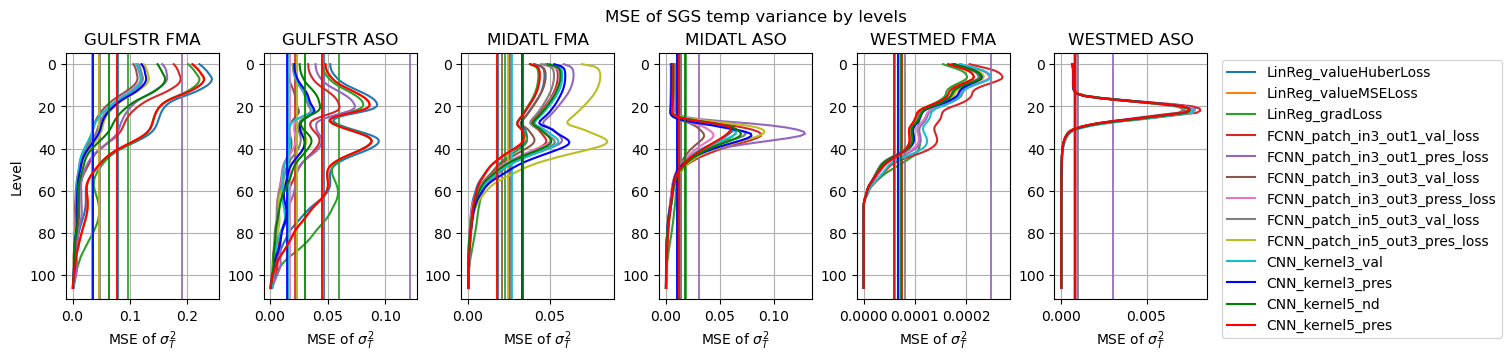

In [66]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.5))
y_vals = np.arange(truth['votemper_var'][idx_region].shape[1])
fig.suptitle('MSE of SGS temp variance by levels')

for idx_region in range(len(data_dict)) :
    line_counter=0
    for i, model in enumerate(list_of_models) :
        x_vals = np.nanmean((model['pred']['votemper_var_masked'][idx_region]-\
                             truth['votemper_var'][idx_region])**2, axis=(0,2,3))
        ax[idx_region].plot(x_vals, y_vals, label=model['label'], ls='-', color=bar_colors[i])
        ax[idx_region].axvline(model['votemper_var']['loss_val'][idx_region], color=bar_colors[i], ls='-', lw=1.25)
    ax[idx_region].invert_yaxis() 
    ax[idx_region].set(title=data_dict[idx_region]['label'],xlabel=r'MSE of $\sigma_T^2$')
    ax[idx_region].grid(True)
ax[0].set(ylabel='Level')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Pressure

## Compute

In [67]:
[truth['pressure_grad_x'], truth['pressure_grad_y'], truth['pressure_grad_norm']] = [[np.empty(shape=1) for i in range(len(data_dict))] for j in range(3)]

for idx_region in range(len(data_dict)) :
    dx = truth['e1t'][idx_region]
    dy = truth['e2t'][idx_region]
    [truth['pressure_grad_x'][idx_region], truth['pressure_grad_y'][idx_region], truth['pressure_grad_norm'][idx_region]] = \
    myParam3Ddata.get_pressure_grad(truth['votemper_var'][idx_region], truth['rho_ct_ct'][idx_region], dx, dy)

In [ ]:
for i, model in enumerate(list_of_models) :
    pred = model['pred']
    [pred['pressure_grad_x'], pred['pressure_grad_y'], pred['pressure_grad_norm'], pred['pressure_grad_x_MSE'], pred['pressure_grad_y_MSE']] \
        = [[torch.Tensor() for i in range(len(data_dict))] for j in range(5)]
    for idx_region in range(len(data_dict)) :
        dx = truth['e1t'][idx_region]
        dy = truth['e2t'][idx_region]
        [pred['pressure_grad_x'][idx_region], pred['pressure_grad_y'][idx_region], pred['pressure_grad_norm'][idx_region]] \
        = myParam3Ddata.get_pressure_grad(pred['votemper_var_masked'][idx_region], truth['rho_ct_ct'][idx_region], dx, dy)
        pred['pressure_grad_x_MSE'][idx_region] = (pred['pressure_grad_x'][idx_region]-truth['pressure_grad_x'][idx_region])**2
        pred['pressure_grad_y_MSE'][idx_region] = (pred['pressure_grad_y'][idx_region]-truth['pressure_grad_y'][idx_region])**2

In [ ]:
def evaluate_tensor_metrics_with_mask(metrics, mask, truth, model_output, reduction='mean') :
    if (len(model_output.shape) == 3) : # 1 feature (1 channel) and 1 level - 3D tensor
        batch_len, output_h, output_w = model_output.shape  
        valid_mask_counts = torch.count_nonzero(mask)
        mask = mask

    if (len(model_output.shape) == 4) : # 1 feature (1 channel) - 4D tensor
        batch_len, nb_of_levels, output_h, output_w = model_output.shape  
        valid_mask_counts = torch.count_nonzero(mask)*nb_of_levels
        mask = mask[:,None,:,:]

    if (len(model_output.shape) == 5) : # full 5D tensor
        batch_len, nb_of_levels, nb_of_channels, output_h, output_w = model_output.shape  
        valid_mask_counts = torch.count_nonzero(mask)*nb_of_levels*nb_of_channels
        mask = mask[:,None,None,:,:]

    if (reduction=='none') : 
        return metrics(model_output*mask, truth*mask, reduction='none')

    total_metrics = metrics(model_output*mask, truth*mask, reduction='sum')
    if (reduction=='mean') : 
        return (total_metrics/valid_mask_counts)
    if (reduction=='sum') : 
        return (total_metrics)

In [ ]:
mask = model['pred']['mask'][0]

In [ ]:
evaluate_tensor_metrics_with_mask(torch.nn.functional.mse_loss, mask, model['pred']['pressure_grad_x'][0]*mask, truth['pressure_grad_x'][0]*mask, reduction='mean')

## Plots of pressure grad norm

In [ ]:
idx_region = 0
idx_batch = 0

fig, ax = plt.subplots(1, len(random_points), constrained_layout=True, figsize=(3*len(random_points), 3), sharex=False,sharey=False)
y_vals = np.arange(truth['pressure_grad_x'][0].shape[1])
fig.suptitle(r'Horizontal pressure gradient $||\nabla_H p||$ at random points from dataset '+data_dict[idx_region]['label'])

for idx, point in enumerate(random_points):
    x = point['x']
    y = point['y']
    x_vals = truth['pressure_grad_norm'][idx_region][idx_batch,:,x,y]
    ax[idx].plot(x_vals, y_vals, label='Truth', lw=5, color='k')
    for i, model in enumerate(list_of_models) :
        x_vals = model['pred']['pressure_grad_norm'][idx_region][idx_batch,:,x,y]
        ax[idx].plot(x_vals, y_vals, label=model['label'], color=bar_colors[i])
    ax[idx].invert_yaxis() 
    ax[idx].set(xlabel=r'Pressure gradient norm $|\nabla p|$', title='Point '+str(idx))
    ax[idx].grid(True)
ax[0].set(ylabel='Level')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3))
y_vals = np.arange(truth['pressure_grad_x'][0].shape[1])
fig.suptitle('Average pressure gradient norm by levels')

for idx_region in range(len(data_dict)) :
    ax[idx_region].plot(np.nanmean(truth['pressure_grad_norm'][idx_region], axis=(0,2,3)), y_vals, label='Truth', lw=5, color='k')
    for i, model in enumerate(list_of_models) :
        x_vals = np.nanmean(model['pred']['pressure_grad_norm'][idx_region][:,:,:], axis=(0,2,3))
        ax[idx_region].plot(x_vals, y_vals, label=model['label'], ls='-', color=bar_colors[i])
    ax[idx_region].invert_yaxis() 
    ax[idx_region].set(title=data_dict[idx_region]['label'],xlabel=r'Pressure gradient $|\nabla p|$')
    ax[idx_region].grid(True)
ax[0].set(ylabel='Level')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=len(list_of_models)+1, constrained_layout=True, figsize=(2*(len(list_of_models)+1),3),sharex=True, sharey=True)
feature = 'pressure_grad_norm'
idx_batch = 0
idx_level = 100
idx_region = 0
fig.suptitle('Maps of ' + feature + ' in ' + data_dict[idx_region]['label'] + ' at 100th level')

img = axs[0].imshow(truth[feature][idx_region][idx_batch,idx_level,:,:], cmap='ocean_r', origin='lower')
fig.colorbar(img, location='left',  shrink=0.8)
axs[0].set(title='Truth')
color_min = img.colorbar.vmin
color_max = img.colorbar.vmax
current_cmap = img.cmap
current_cmap.set_bad(color='silver')

for i, model in enumerate(list_of_models) :
    img = axs[i+1].imshow(model['pred'][feature][idx_region][idx_batch,idx_level,:,:], cmap=current_cmap, \
                                       vmin=color_min, vmax=color_max, origin='lower')
    axs[i+1].set(title=model['label'])
fig.colorbar(img, ax=axs[-1], shrink=0.8)
plt.show()

## MSE by vertical level

In [ ]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3))
y_vals = np.arange(truth['pressure_grad_x'][0].shape[1])
fig.suptitle('MSE pressure gradient by levels')

for idx_region in range(len(data_dict)) :
    line_counter=1
    for i, model in enumerate(list_of_models) :
        x_vals = np.nanmean(model['pred']['pressure_grad_x_MSE'][idx_region]+model['pred']['pressure_grad_y_MSE'][idx_region], axis=(0,2,3))
        ax[idx_region].plot(x_vals, y_vals, label=model['label'], ls='-', color=bar_colors[i])
    ax[idx_region].invert_yaxis() 
    ax[idx_region].set(title=data_dict[idx_region]['label'],xlabel=r'MSE of $\nabla \vec{p}$')
    ax[idx_region].grid(True)
ax[0].set(ylabel='Level')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=len(list_of_models), constrained_layout=True, figsize=(2*(len(list_of_models)),3),sharex=True, sharey=True)
idx_batch = 0
idx_level = 100
idx_region = 0
fig.suptitle('Maps error of ' + feature + ' in ' + data_dict[idx_region]['label'] + ' at depth')

for i, model in enumerate(list_of_models) :
    img = axs[i].imshow((model['pred']['pressure_grad_x_MSE'][idx_region]+model['pred']['pressure_grad_y_MSE'][idx_region])[idx_batch,idx_level,:,:], \
                          cmap=('ocean_r' if (i==0) else current_cmap), \
                          vmin=(None if (i==0) else color_min), vmax=(None if (i==0) else color_max), \
                          origin='lower')
    if i==0 :
        fig.colorbar(img, location='left',  shrink=0.8)
        color_min = img.colorbar.vmin
        color_max = img.colorbar.vmax
        current_cmap = img.cmap
        current_cmap.set_bad(color='silver')
    axs[i].set(title=model['label'])
    axs[i].title.set_size(9)
fig.colorbar(img, ax=axs[-1], shrink=0.8)
plt.show()

## Total MSE by dataset

In [ ]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.0), sharex=True, sharey=False)
fig.suptitle('MSE of pressure gradient OVER ALL THE CUBE')
bar_width = 0.15
x = np.arange(3)
for idx_region in range(len(data_dict)) :
    versions = [0 for i in x]
    for idx_model, model in enumerate(list_of_models) :
        i = xlabels.index(model['model_name'])
        j = versions[i]        
        bar_value = np.nanmean(model['pred']['pressure_grad_x_MSE'][idx_region]+model['pred']['pressure_grad_y_MSE'][idx_region])
        ax[idx_region].bar(x[i]+j*bar_width, bar_value, width=bar_width, label=model['label'])
        versions[i]+=1
    ax[idx_region].set_xticks(x, xlabels, rotation='vertical')
    ax[idx_region].set(title=data_dict[idx_region]['label'])
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## MSE at deep level

In [ ]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.0), sharex=True, sharey=False)
fig.suptitle('MSE of pressure gradient at level N100')
bar_width = 0.15
x = np.arange(3)
for idx_region in range(len(data_dict)) :
    versions = [0 for i in x]
    for idx_model, model in enumerate(list_of_models) :
        i = xlabels.index(model['model_name'])
        j = versions[i]        
        bar_value = np.nanmean((model['pred']['pressure_grad_x_MSE'][idx_region]+model['pred']['pressure_grad_y_MSE'][idx_region])[:,100,:,:])
        ax[idx_region].bar(x[i]+j*bar_width, bar_value, width=bar_width, label=model['label'])
        versions[i]+=1
    ax[region].set_xticks(x, xlabels, rotation='vertical')
    ax[region].set(title=data_dict[region]['label'])
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Logged metrics

In [ ]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.24), sharex=True, sharey=False)
fig.suptitle('MSE of pressure gradient at level N100')
bar_width = 0.15
x = np.arange(3)
for region in range(len(data_dict)) :
    versions = [0 for i in x]
    for idx_model, model in enumerate(list_of_models) :
        i = xlabels.index(model['model_name'])
        j = versions[i]        
        bar_value = model['pressure_grad']['loss_val'][region]
        ax[region].bar(x[i]+j*bar_width, bar_value, width=bar_width, label=model['label'])
        versions[i]+=1
    ax[region].set_xticks(x, xlabels, rotation='vertical')
    ax[region].set(title=data_dict[region]['label'])
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Metrics evaluated in the test stage show higher MSE in general most likely because of the border points, since in the test stage the errors are evaluated on not masked fields. In the error evaluated on prediction, the bordeer points are excluded